In [1]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
from pathlib import Path
import warnings
import random
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tqdm import tqdm_notebook

from fastmri_recon.config import CHECKPOINTS_DIR
from fastmri_recon.data.sequences.oasis_sequences import Masked2DSequence, ZeroFilled2DSequence
from fastmri_recon.evaluate.reconstruction.zero_filled_reconstruction import reco_and_gt_zfilled_from_val_file
from fastmri_recon.evaluate.reconstruction.cross_domain_reconstruction import reco_and_gt_net_from_val_file
from fastmri_recon.evaluate.reconstruction.unet_reconstruction import reco_and_gt_unet_from_val_file 
from fastmri_recon.models.functional_models.cascading import cascade_net
from fastmri_recon.models.functional_models.kiki import kiki_net
from fastmri_recon.models.functional_models.kiki_sep import full_kiki_net
from fastmri_recon.models.functional_models.pdnet import pdnet
from fastmri_recon.models.functional_models.unet import unet
from fastmri_recon.models.utils.non_linearities import lrelu

In [3]:
np.random.seed(0)

In [4]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'

In [5]:
AF = 4

In [6]:
# paths
train_path = '/media/Zaccharie/UHRes/OASIS_data/'
train_gen = Masked2DSequence(
    train_path,
    af=AF,
    inner_slices=32,
    scale_factor=1e-2,
    seed=0,
    rand=True,
    val_split=0.1,
)
val_gen_mask = train_gen.val_sequence
n_train = 1000
n_val = 200
random.seed(0)
train_gen.filenames = random.sample(train_gen.filenames, n_train)
val_gen_mask.filenames = random.sample(val_gen_mask.filenames, n_val)

train_gen_zero = ZeroFilled2DSequence(
    train_path,
    af=AF,
    inner_slices=32,
    scale_factor=1e-2,
    seed=0,
    rand=False,
    val_split=0.1,
    n_pooling=3,
)
val_gen_zero = train_gen_zero.val_sequence
random.seed(0)
train_gen_zero.filenames = random.sample(train_gen_zero.filenames, n_train)
val_gen_zero.filenames = random.sample(val_gen_zero.filenames, n_val)

In [7]:
val_gen_mask.filenames[0]

'/media/Zaccharie/UHRes/OASIS_data/OAS30367_MR_d3396/anat4/NIFTI/sub-OAS30367_ses-d3396_T1w.nii.gz'

In [8]:
val_gen_zero.filenames[0]

'/media/Zaccharie/UHRes/OASIS_data/OAS30367_MR_d3396/anat4/NIFTI/sub-OAS30367_ses-d3396_T1w.nii.gz'

In [9]:
kspace = val_gen_mask[0][0][0]

<IPython.core.display.Javascript object>


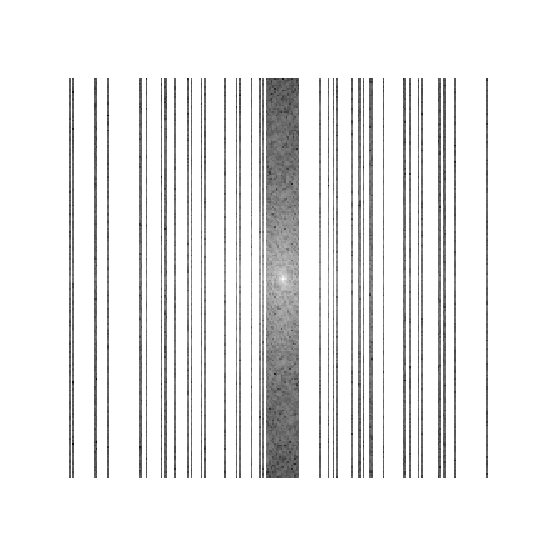

(-0.5, 255.5, 239.5, -0.5)

In [10]:
plt.figure()
plt.imshow(np.log(np.abs(np.squeeze(kspace[15]))))
plt.axis('off')

In [11]:
all_net_params = [
    {
        'name': 'unet',
        'init_function': unet,
        'run_params': {
            'n_layers': 4,
            'pool': 'max',
            "layers_n_channels": [16, 32, 64, 128],
            'layers_n_non_lins': 2,
        },
        'val_gen': val_gen_zero,
        'run_id': 'UNet-OASIS',
        'reco_function': reco_and_gt_net_from_val_file,
    },
    {
        'name': 'pdnet',
        'init_function': pdnet,
        'run_params': {
            'n_primal': 5,
            'n_dual': 5,
            'n_iter': 10,
            'n_filters': 32,
        },
        'run_id': 'PDNet-OASIS',
        'reco_function': reco_and_gt_net_from_val_file,
    },
    {
        'name': 'cascadenet',
        'init_function': cascade_net,
        'run_params': {
            'n_cascade': 5,
            'n_convs': 5,
            'n_filters': 48,
            'noiseless': True,
        },
        'run_id': 'CascadeNet-OASIS',
        'reco_function': reco_and_gt_net_from_val_file,
    },
        {
        'name': 'kikinet-sep',
        'init_function': full_kiki_net,
        'run_params': {
            'n_convs': 16,
            'n_filters': 48,
            'noiseless': True,
            'activation': lrelu,
        },
        'run_id': 'KIKI-net-OASIS',
        'epoch': 50,
        'reco_function': reco_and_gt_net_from_val_file,
    },
]

In [12]:
image_index = 18
slice_index = 15
def unpack_model(init_function=None, run_params=None, run_id=None, epoch=300, **dummy_kwargs):
    try:
        model = init_function(input_size=(None, None, 1), fastmri=False, **run_params)
    except:
        model = init_function(input_size=(None, None, 1), **run_params)
    chkpt_path = Path(CHECKPOINTS_DIR) / f'{run_id}.hdf5'
    model.load_weights(chkpt_path)
    return model

def save_figure(im_recos, img_batch, name):
    im_reco = im_recos[slice_index]
    im_gt = img_batch[slice_index]
    im_res = np.abs(im_gt - im_reco)
    fig, ax = plt.subplots(1, frameon=False)
    ax.imshow(np.abs(np.squeeze(im_reco)), aspect='auto')
    ax.axis('off')
    fig.savefig(f'figures/{name}_recon_af{AF}_oasis.png')
    fig, ax = plt.subplots(1, frameon=False)
    ax.imshow(np.abs(np.squeeze(im_res)), aspect='auto')
    ax.axis('off')
    fig.savefig(f'figures/{name}_residu_af{AF}_oasis.png')
    

def save_figure_for_params(reco_function=None, val_gen=None, name=None, **net_params):
    if val_gen is None:
        val_gen = val_gen_mask
    model = unpack_model(**net_params)
    im_recos, img_batch = reco_function(*val_gen[image_index], model)
#     im_recos = np.copy(im_recos)
#     im_batch = np.copy(im_batch)
    im_recos = im_recos / 1e-2
    img_batch = img_batch / 1e-2
    save_figure(im_recos, img_batch, name)
    
    
def save_figure_zfilled():  
    im_recos, img_batch = reco_and_gt_zfilled_from_val_file(*val_gen_mask[image_index], crop=False)
    im_recos /= 1e-2
    img_batch /= 1e-2
    save_figure(im_recos, img_batch, 'zfilled')

<IPython.core.display.Javascript object>


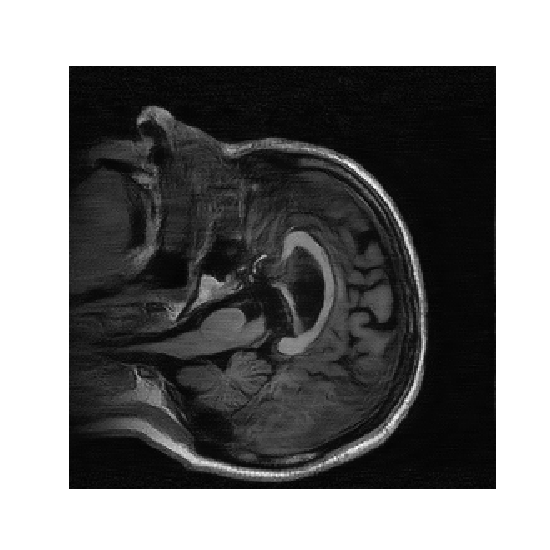

<IPython.core.display.Javascript object>


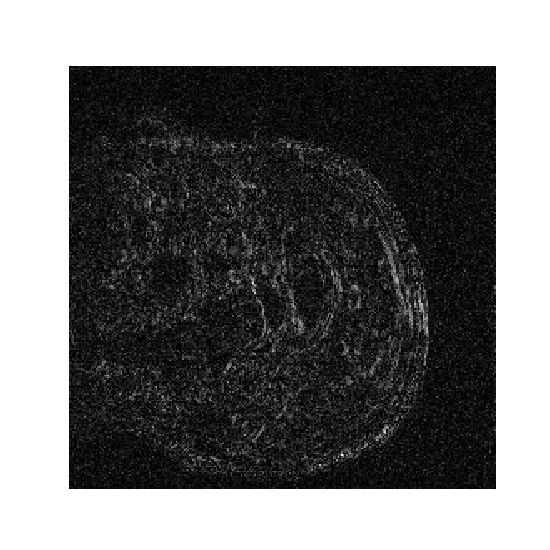

<IPython.core.display.Javascript object>


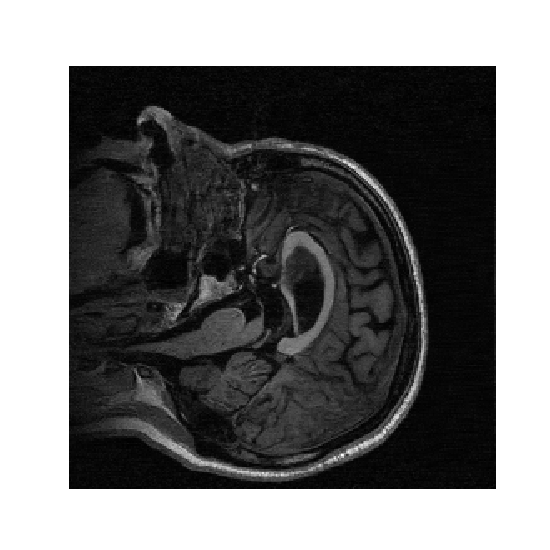

<IPython.core.display.Javascript object>


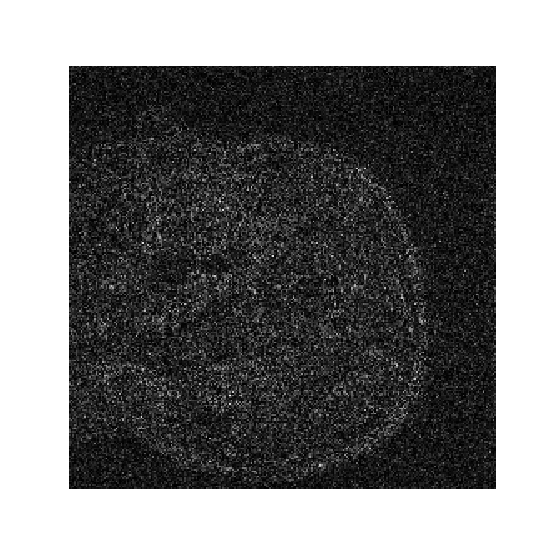

<IPython.core.display.Javascript object>


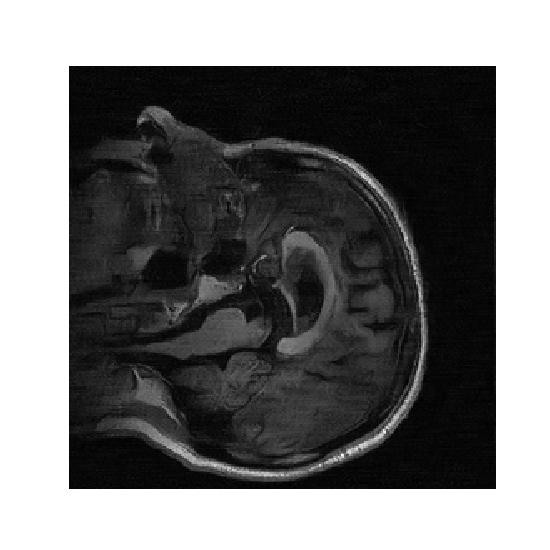

<IPython.core.display.Javascript object>


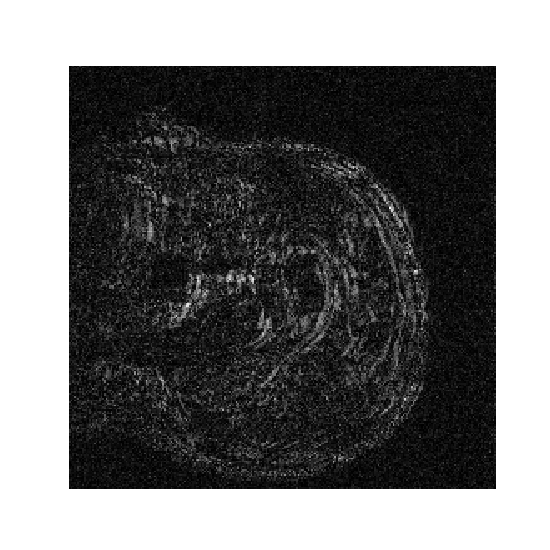

<IPython.core.display.Javascript object>


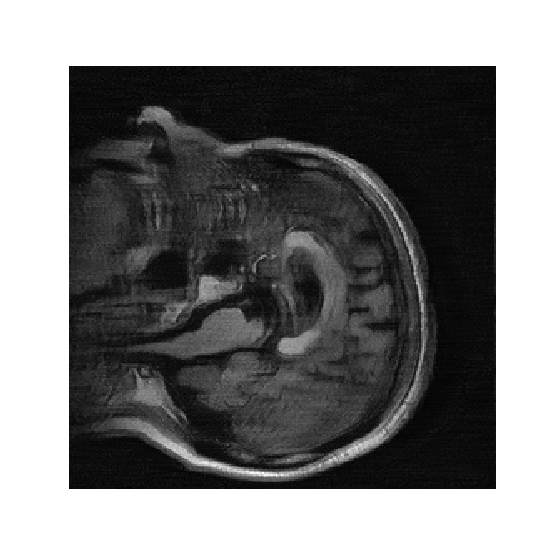

<IPython.core.display.Javascript object>


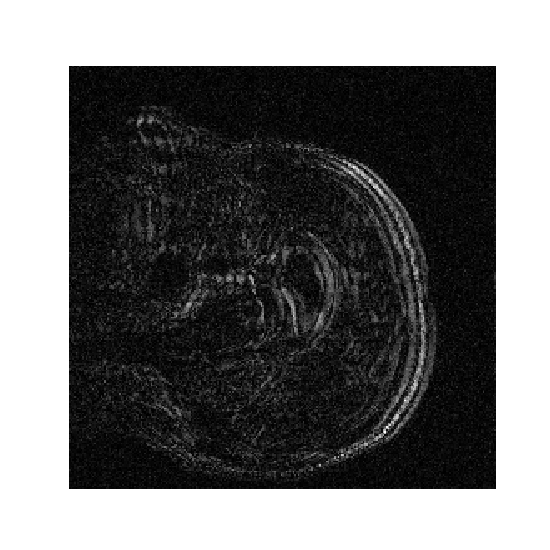

<IPython.core.display.Javascript object>


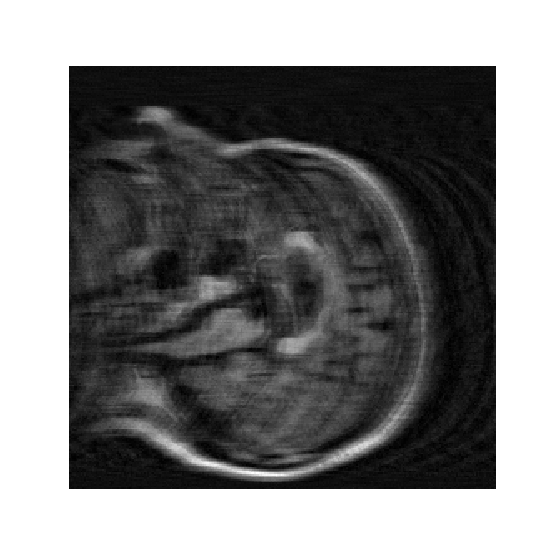

<IPython.core.display.Javascript object>


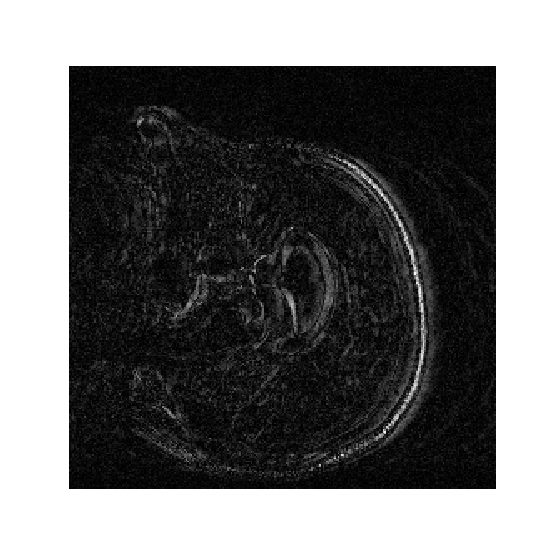

CPU times: user 19.2 s, sys: 4.69 s, total: 23.9 s
Wall time: 22.9 s


In [13]:
%%time
for net_params in all_net_params:
    save_figure_for_params(**net_params)
    
save_figure_zfilled()

<IPython.core.display.Javascript object>


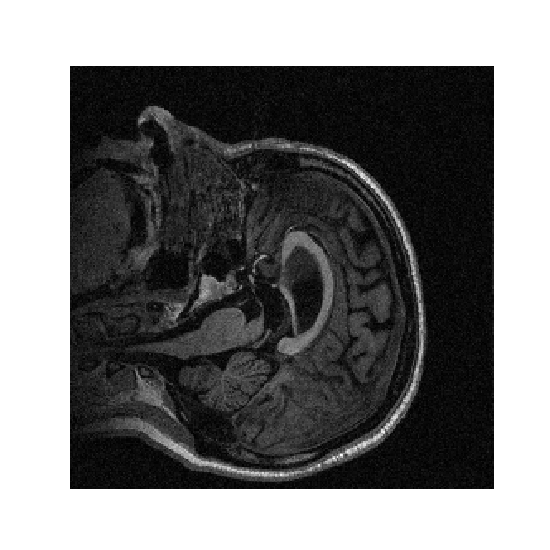

In [15]:
_, img_batch = val_gen_mask[image_index]
img_batch /= 1e6
im_gt = img_batch[slice_index]
fig, ax = plt.subplots(1)
ax.imshow(np.abs(np.squeeze(im_gt)))
ax.axis('off')
fig.savefig(f'figures/image_gt.png')